In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import contextily as ctx
import copy
from scipy.stats import norm
from plot_functions import plot_vakindeling, plot_assessment_betas, plot_assessment_probabilities
from load_output import read_assessment_betas

In [2]:
shape_dir = Path(r'n:\Projects\11208000\11208392\C. Report - advise\Gegevens 16-1')
results_dir = shape_dir.joinpath('rerun')
run = 'results'
# shapefile = gpd.read_file(shape_dir.joinpath('00_data_workflow','intermediate','Vakindeling_Veiligheidsrendement.shp'))
shapefile = gpd.read_file(shape_dir.joinpath('intermediate','Vakindeling_Veiligheidsrendement.shp'))

shapefile.crs='EPSG:28992'
shapefile = shapefile.to_crs(epsg=3857)
# shapefile.to_crs(epsg=4326)
for count, section in shapefile.iterrows():
    if len(section.NUMMER) ==1:
        #pad 0:
        shapefile.loc[count,'NUMMER']= '{:02d}'.format(np.int32(section.NUMMER))

## Plot vakindeling

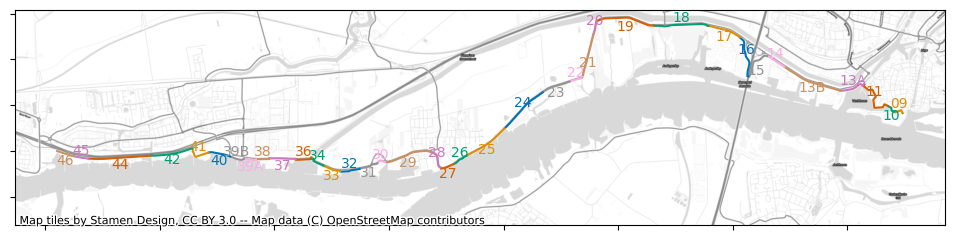

In [3]:
plot_vakindeling(shapefile, results_dir.joinpath(run, 'extra_resultaten', 'vakindeling.png'))

## Plot beoordeling

In [4]:
InitialAssessmentBetas, InitialAssessmentProbabilities = read_assessment_betas(results_dir.joinpath(run, 'InitialAssessment_Betas.csv'))

In [6]:
plot_assessment_betas(shapefile, InitialAssessmentBetas, results_dir.joinpath(run,'extra_resultaten'), year = 2025)

plot_assessment_probabilities(shapefile, InitialAssessmentProbabilities, results_dir.joinpath(run,'extra_resultaten'), year = 2025)

plot_assessment_probabilities(shapefile, InitialAssessmentProbabilities, results_dir.joinpath(run,'extra_resultaten'), year = 2075)



## Maatregelen

### Versterkte lengte

In [18]:
def beta_to_pf(beta):
    # alternative: use scipy
    return norm.cdf(-beta)


def pf_to_beta(pf):
    # alternative: use scipy
    return -norm.ppf(pf)

def get_traject_prob(beta_df, mechanisms = ['StabilityInner','Piping','Overflow']):
    beta_df = beta_df.reset_index().set_index('mechanism').drop(columns=['name'])
    traject_probs = dict((el,[]) for el in mechanisms)
    total_traject_prob = np.empty((1,beta_df.shape[1]))
    for mechanism in mechanisms:
        if mechanism == 'Overflow':
            #take min beta in each column
            traject_probs[mechanism] = beta_to_pf(beta_df.loc[mechanism].min().values)
        else:
            pf_df = beta_to_pf(beta_df.loc[mechanism].values)
            pnonf_df = np.subtract(1,pf_df)
            pnonf_traject = np.product(pnonf_df,axis=0)
            traject_probs[mechanism] = 1-pnonf_traject
            #convert to probability
            #1-prod(1-p)
        total_traject_prob += traject_probs[mechanism]
    return total_traject_prob, traject_probs
    
def get_traject_prob_development(optimal_measures,taken_measures,calc_type='Veiligheidsrendement',mechanisms= ['StabilityInner','Piping','Overflow']):
    section_order = taken_measures['Section'].dropna().unique()
    beta_dfs = []
    #begin_betas:
    beta_dfs.append(InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism!='Section'].set_index(['name','mechanism']).drop(columns=['Length']))
    sections_without_measures = []
    for count, section in enumerate(section_order,1):
        beta_df = copy.deepcopy(beta_dfs[-1])
        # print('Original')
        # maatregel lezen:
        # option_index = taken_measures.loc[optimal_measures.loc[section]['Unnamed: 0']].option_index
        # vr_measure = pd.read_csv(results_dir.joinpath(run,'{}_Options_{}.csv'.format(section,calc_type)),index_col=0).loc[option_index]
        measure_data = taken_measures.loc[optimal_measures.loc[section]['Unnamed: 0']]
        # print(measure_data)
        if not isinstance(measure_data.ID,str):
            # print(section)
            sections_without_measures.append(section)
        else:
            vr_measure = pd.read_csv(results_dir.joinpath(run,'{}_Options_{}.csv'.format(section,calc_type)),index_col=0)

            vr_measure = vr_measure.loc[(vr_measure.ID == measure_data.ID) & (vr_measure['yes/no'] == measure_data['yes/no']) 
                                        & (vr_measure.dcrest == measure_data.dcrest) & (vr_measure.dberm == measure_data.dberm)].squeeze()
            # print(vr_measure)
            for mechanism in mechanisms:

                mask = vr_measure.index.str.startswith(mechanism)
                betas = vr_measure.loc[mask].values

                beta_df.loc[(section[2:],mechanism),:]=betas


            beta_dfs.append(beta_df)
            # print('added {} with {}'.format(section,vr_measure.type))
    section_order = [x for x in section_order if x not in sections_without_measures]
    # section_order = list(section_order)
    # print(np.where(section_order in sections_without_measures))
    # for count, section in enumerate(section_order):
    #     if section in sections_without_measures:
    #         section_order.remove(count)
    traject_probs = np.empty((len(beta_dfs),7))
    raw_traject_probs = []
    for count, beta_df in enumerate(beta_dfs):
        traject_probs[count,:], raw_traject_prob = get_traject_prob(beta_df,mechanisms=mechanisms)
        raw_traject_probs.append(raw_traject_prob)
    return section_order,traject_probs


In [19]:
#optimale maatregelen
optimal_measures_vr = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Optimal_Veiligheidsrendement.csv'),index_col=2)
#maatregelvolgorde, optie 1: eerste investering als eerste
taken_measures_vr = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Veiligheidsrendement.csv'),index_col=0)
section_order_vr, traject_probs_vr = get_traject_prob_development(optimal_measures_vr,taken_measures_vr)

In [20]:
#optimale maatregelen
optimal_measures_dsn = pd.read_csv(results_dir.joinpath(run,'FinalMeasures_Doorsnede-eisen.csv'),index_col=2)
#maatregelvolgorde, optie 1: eerste investering als eerste
taken_measures_dsn = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Doorsnede-eisen.csv'),index_col=0)
section_order_dsn, traject_probs_dsn = get_traject_prob_development(optimal_measures_dsn,taken_measures_dsn,calc_type='Doorsnede-eisen')

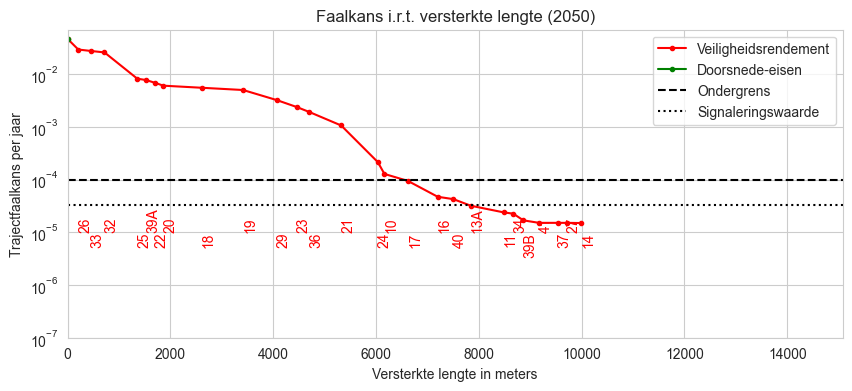

In [22]:
def get_cum_length(section_order,section_lengths):
    sections_stripped = [item.strip('DV') for item in section_order]
    cum_lengths = section_lengths.loc[sections_stripped].cumsum()
    return cum_lengths

year_ind = 3
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
section_lengths = InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism=='Section'].set_index('name')['Length']
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_length(section_order_vr,section_lengths)])
x_dsn = pd.concat([pd.Series([0]), get_cum_length(section_order_dsn,section_lengths)])
ax.plot(x_vr,traject_probs_vr[:,year_ind],label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,traject_probs_dsn[:,year_ind],label= 'Doorsnede-eisen',color='green',marker='.')
ax.hlines(1./10000,0,shapefile.MEAS_END.max(),label='Ondergrens',color='k',linestyle='--')

ax.hlines(1./30000,0,shapefile.MEAS_END.max(),label='Signaleringswaarde',color='k',linestyle=':')
#text labels vr:
for count, section in enumerate(section_order_vr,1):
    if (count % 2) == 0:
        ax.text(x_vr.iloc[count],1e-5,section.strip('DV'),rotation=90,verticalalignment='top',color='red')
    else:
        ax.text(x_vr.iloc[count],1e-5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='red')
        
#text labels dsn:
for count, section in enumerate(section_order_dsn,1):
    if (count % 2) == 0:
        ax.text(x_dsn.iloc[count],1e-6,section.strip('DV'),rotation=90,verticalalignment='top',color='green')
    else:
        ax.text(x_dsn.iloc[count],1e-6,section.strip('DV'),rotation=90,verticalalignment='bottom',color='green')
ax.set_yscale('log')
ax.set_xlim(left=0,right=shapefile.MEAS_END.max())
ax.set_ylim(bottom=1e-7)
ax.set_title('Faalkans i.r.t. versterkte lengte ({})'.format(year))
ax.set_ylabel('Trajectfaalkans per jaar')
ax.set_xlabel('Versterkte lengte in meters')
ax.legend()
plt.savefig(results_dir.joinpath(run,'extra_resultaten','versterkte lengte vs faalkans in {}.png'.format(year)),dpi=300,bbox_inches='tight')

Zelfde figuur, maar dan niet met lengte maar met kosten

ValueError: Axis limits cannot be NaN or Inf

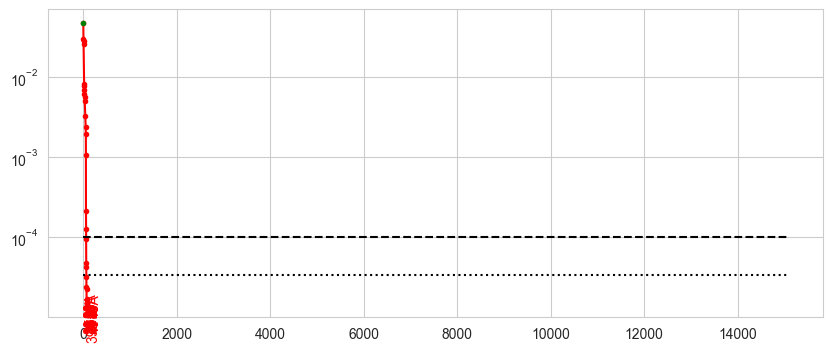

In [80]:
def get_cum_costs(section_order,measure_costs):
    return measure_costs.loc[section_order]['LCC'].cumsum()/1e6

year_ind = 3
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(section_order_vr,optimal_measures_vr)])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(section_order_dsn,optimal_measures_dsn)])
ax.plot(x_vr,traject_probs_vr[:,year_ind],label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,traject_probs_dsn[:,year_ind],label= 'Doorsnede-eisen',color='green',marker='.')
ax.hlines(1./10000,0,shapefile.MEAS_END.max(),label='Ondergrens',color='k',linestyle='--')

ax.hlines(1./30000,0,shapefile.MEAS_END.max(),label='Signaleringswaarde',color='k',linestyle=':')
#text labels vr:
for count, section in enumerate(section_order_vr,1):
    if (count % 2) == 0:
        ax.text(x_vr.iloc[count],1e-5,section.strip('DV'),rotation=90,verticalalignment='top',color='red')
    else:
        ax.text(x_vr.iloc[count],1e-5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='red')
        
#text labels dsn:
for count, section in enumerate(section_order_dsn,1):
    if (count % 2) == 0:
        ax.text(x_dsn.iloc[count],1e-6,section.strip('DV'),rotation=90,verticalalignment='top',color='green')
    else:
        ax.text(x_dsn.iloc[count],1e-6,section.strip('DV'),rotation=90,verticalalignment='bottom',color='green')
ax.set_yscale('log')
x_max_right = np.max([get_cum_costs(section_order_vr,optimal_measures_vr).max(),get_cum_costs(section_order_dsn,optimal_measures_dsn).max()])
ax.set_xlim(left=0,right=x_max_right)
ax.set_ylim(bottom=1e-7)
ax.set_title('Faalkans i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Trajectfaalkans per jaar')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend()
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten vs faalkans in {}.png'.format(year)),dpi=300,bbox_inches='tight')


In [ ]:
year_ind = 3
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(section_order_vr,optimal_measures_vr)])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(section_order_dsn,optimal_measures_dsn)])
ax.plot(x_vr,-norm.ppf(traject_probs_vr[:,year_ind]),label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,-norm.ppf(traject_probs_dsn[:,year_ind]),label= 'Doorsnede-eisen',color='green',marker='.')
ax.hlines(-norm.ppf(1./10000),0,shapefile.MEAS_END.max(),label='Ondergrens',color='k',linestyle='--')

ax.hlines(-norm.ppf(1./30000),0,shapefile.MEAS_END.max(),label='Signaleringswaarde',color='k',linestyle=':')
#text labels vr:
for count, section in enumerate(section_order_vr,1):
    if (count % 2) == 0:
        ax.text(x_vr.iloc[count],4.5,section.strip('DV'),rotation=90,verticalalignment='top',color='red')
    else:
        ax.text(x_vr.iloc[count],4.5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='red')
        
#text labels dsn:
for count, section in enumerate(section_order_dsn,1):
    if (count % 2) == 0:
        ax.text(x_dsn.iloc[count],5,section.strip('DV'),rotation=90,verticalalignment='top',color='green')
    else:
        ax.text(x_dsn.iloc[count],5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='green')
# ax.set_yscale('log')
x_max_right = np.max([get_cum_costs(section_order_vr,optimal_measures_vr).max(),get_cum_costs(section_order_dsn,optimal_measures_dsn).max()])
ax.set_xlim(left=0,right=x_max_right)
ax.set_ylim(top=5.5)
ax.set_title('Betrouwbaarheidsindex i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Betrouwbaarheidsindex op trajectniveau')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend(loc='lower right')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten vs beta in {}.png'.format(year)),dpi=300,bbox_inches='tight')


Vergelijking optimalisatiepad, versus veiligheidsrendement opgebost per vak.

In [ ]:
year_ind = 0 #2025
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(section_order_vr,optimal_measures_vr)])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(section_order_dsn,optimal_measures_dsn)])
ax.plot(x_vr,-norm.ppf(traject_probs_vr[:,year_ind]),label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,-norm.ppf(traject_probs_dsn[:,year_ind]),label= 'Doorsnede-eisen',color='green',marker='.')

optimal_path = pd.read_csv(results_dir.joinpath(run, 'Beta vs LCC_Optimized investment_t2025.csv'),index_col=0)
ax.plot(optimal_path.Cost,optimal_path.beta,color='red',linestyle='--',label='Optimaal pad VR')

dsn_path = pd.read_csv(results_dir.joinpath(run, 'Beta vs LCC_Target reliability based investment_t2025.csv'),index_col=0)
ax.plot(dsn_path.Cost,dsn_path.beta,color='green',linestyle='--',label='Pad doorsnede-eisen')

ax.hlines(-norm.ppf(1./10000),0,shapefile.MEAS_END.max(),label='Ondergrens',color='k',linestyle='--')
ax.hlines(-norm.ppf(1./30000),0,shapefile.MEAS_END.max(),label='Signaleringswaarde',color='k',linestyle=':')


ax.set_xlim(left=0,right=get_cum_costs(section_order_dsn,optimal_measures_dsn).max())
ax.set_ylim(top=5.5)
ax.set_title('Betrouwbaarheidsindex i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Betrouwbaarheidsindex op trajectniveau')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend(loc='lower right')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','vergelijking optimalisatiepad {}.png'.format(year)),dpi=300,bbox_inches='tight')


In [11]:
#dijkvak 46
section='09'
vr_measures = pd.read_csv(results_dir.joinpath(run,'DV{}_Options_Veiligheidsrendement.csv'.format(section)))
# section =69
# safepath = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\04_SAFE\data_repos\cases\Testcase_SAFE_v12_16-3\Case_maatregelen_alle_vakken\results\DV{}_Options_Veiligheidsrendement.csv'.format(section))
# vr_measures = pd.read_csv(safepath)

vr_measures = vr_measures.loc[1:]
LCCs = []
r = 1.015
for count, row in vr_measures.iterrows():
    # if count > 0:
    try:
        LCCs.append(np.float32(row.cost)/((r**np.int32(row.year))))
    except:
        c = row.cost.strip('[').strip(']').split(',')
        t = row.year.strip('[').strip(']').split(',')
        LCC0 = 0
        for i,c0 in enumerate(c):
            LCC0+= np.float32(c0)/(r**np.int32(t[i]))
        LCCs.append(LCC0)
        # raise Exception('fout')
    # else:
    #     LCCs.append(0.)
vr_measures['LCC'] = LCCs

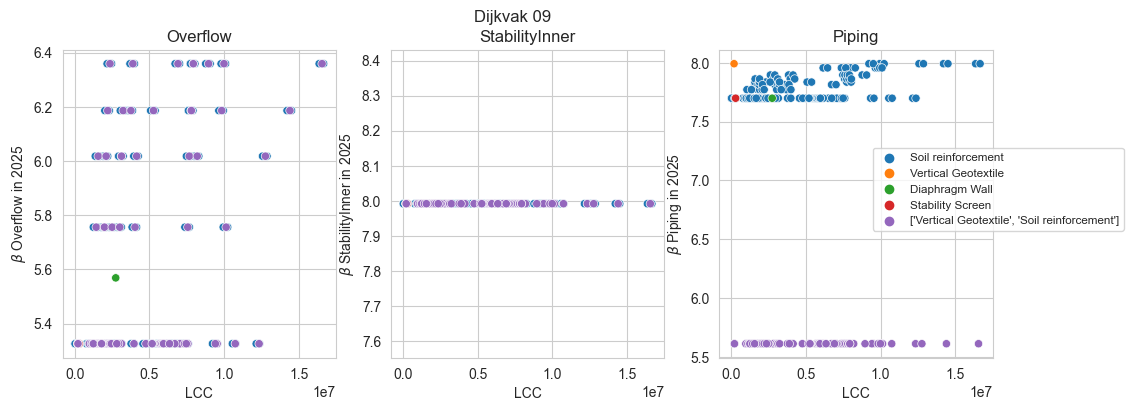

In [12]:
fig, axes = plt.subplots(figsize=(12,4),ncols=3)
for i, mech in enumerate(mechanisms):
    if i!=2:
        sns.scatterplot(ax=axes[i],data=vr_measures,x='LCC',y= '{}.1'.format(mech),hue= 'type',legend=False)
    else:
        sns.scatterplot(ax=axes[i],data=vr_measures,x='LCC',y= '{}.1'.format(mech),hue= 'type')
        axes[i].legend(bbox_to_anchor=(1.5,.7),fontsize='small')
    axes[i].set_title(mech)
    axes[i].set_ylabel(r'$\beta$ {} in 2025'.format(mech))
fig.suptitle('Dijkvak {}'.format(section))
plt.savefig(results_dir.joinpath(run,'extra_resultaten','maatregelen dijkvak {}.png'.format(section)),dpi=300,bbox_inches='tight')


## Resultaten

C:\Users\klerk_wj\Miniconda3\envs\vr_preprocessing\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


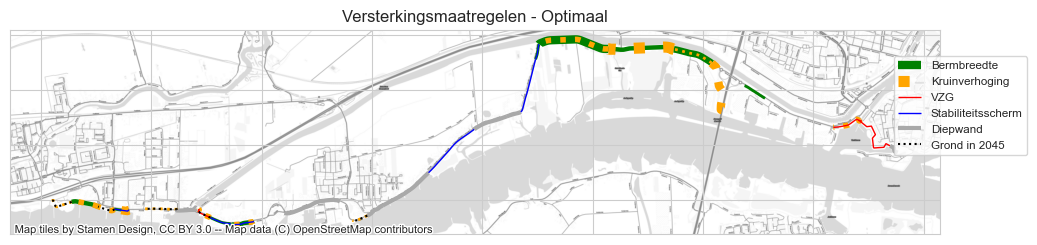

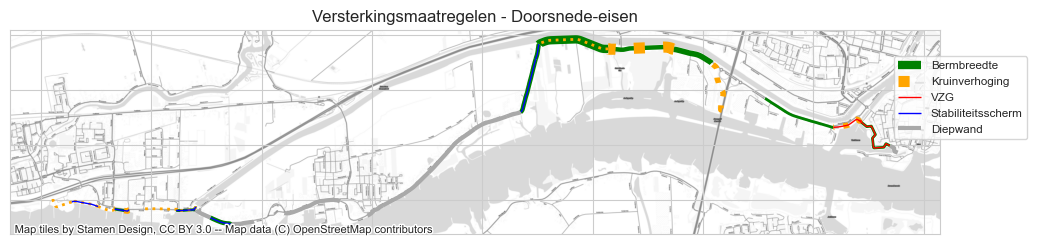

In [13]:
def add_characteristic_columns(result_df):
    #cleaning data
    for count, line in result_df.iterrows():
        try:
            result_df.loc[count,'Section'] = line['Section'].strip('DV')
        except:
            pass
    result_df['In 2045'] = result_df['ID'].str.contains("1", case=False)
    result_df['Stabiliteitsscherm'] = result_df['ID'].str.contains("4|7", case=False)
    result_df['VZG'] = result_df['ID'].str.contains("5", case=False)
    result_df['Diepwand'] = result_df['ID'].str.contains("6", case=False)
    return result_df

def map_of_measures(data,include_crest = True, data_type='Optimaal'):
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5))
    for bermwidth in np.unique(data.dberm):
        if (bermwidth >0) and (bermwidth != np.max(np.unique(data.dberm))):
            data.loc[data.dberm==bermwidth].plot(ax=ax,color='green',linewidth=bermwidth/2.5)
        elif bermwidth >0:

            data.loc[data.dberm==bermwidth].plot(ax=ax,color='green',linewidth=bermwidth/2.5,label='Bermbreedte')
    if include_crest:
        for crestheight in np.unique(data.dcrest):
            if (crestheight >0) and (crestheight != np.max(np.unique(data.dcrest))):

                data.loc[data.dcrest==crestheight].plot(ax=ax,color='orange',linestyle=':',linewidth=crestheight*4)
            elif crestheight >0:

                data.loc[data.dcrest==crestheight].plot(ax=ax,color='orange',linestyle=':',linewidth=crestheight*4,label='Kruinverhoging')
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
        
    data.loc[data.VZG].plot(ax=ax,color='r',linestyle='-',linewidth=1,label='VZG')
    data.loc[data.Stabiliteitsscherm].plot(ax=ax,color='b',linestyle='-',linewidth=1,label='Stabiliteitsscherm')
    data.loc[data.Diepwand].plot(ax=ax,color='darkgray',linestyle='-',linewidth=3,label='Diepwand')
    data.loc[data['In 2045']].plot(ax=ax,color='k',linestyle=':',label='Grond in 2045')

    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
    ax.legend(bbox_to_anchor=(1.1,.9),fontsize='small')
    ax.set_title('Versterkingsmaatregelen - {}'.format(data_type))
    plt.savefig(results_dir.joinpath(run,'extra_resultaten','versterking_{}.png'.format(data_type)),dpi=300,bbox_inches='tight')
                
                
GreedyResult = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Optimal_Veiligheidsrendement.csv'))
GreedyResult = add_characteristic_columns(GreedyResult)
GreedyResult = shapefile.merge(GreedyResult,left_on='NUMMER',right_on='Section')
map_of_measures(GreedyResult)

DsnResult = pd.read_csv(results_dir.joinpath(run,'FinalMeasures_Doorsnede-eisen.csv'))
DsnResult = add_characteristic_columns(DsnResult)
DsnResult = shapefile.merge(DsnResult,left_on='NUMMER',right_on='Section')
map_of_measures(DsnResult,data_type = 'Doorsnede-eisen')


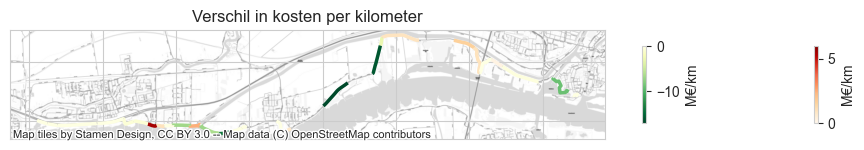

In [14]:
def map_of_measure_cost(data,data_type='Optimaal'):
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5))
    data['cost per km'] = np.divide(data['LCC']/1e6,(data['VAKLENGTE']/1e3))
    data.plot(column='cost per km',ax=ax,cmap='RdYlGn_r',legend=True,vmin=0.1,vmax=20, linewidth=2.5,legend_kwds={'label':'M€/km',"shrink":.4})
    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
    ax.set_title('Kosten per kilometer - {}'.format(data_type))
    plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten_{}.png'.format(data_type)),dpi=300,bbox_inches='tight')

def map_of_measure_cost_diff(data,dif_col, data_type='Optimaal'):
    #dif_col is the column with the difference in LCC
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5))
    data['cost per km (difference)'] = np.divide(data[dif_col]/1e6,(data['VAKLENGTE']/1e3))
    data.loc[data[dif_col]>0].plot(column='cost per km (difference)',ax=ax,cmap='OrRd',legend=True,vmin=0,vmax=np.ceil(np.max(data['cost per km (difference)'])), linewidth=2.5,
                                   legend_kwds={'label':'M€/km',"shrink":.2,'anchor':(0.1,0.5)})
    data.loc[data[dif_col]<0].plot(column='cost per km (difference)',ax=ax,cmap='YlGn_r',legend=True,vmin=np.floor(np.min(data['cost per km (difference)'])),vmax=0, linewidth=2.5,
                                   legend_kwds={'label':'M€/km',"shrink":.2,'anchor':(-.0,0.5)})

    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
    ax.set_title('Verschil in kosten per kilometer')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten_verschil.png'),dpi=300,bbox_inches='tight')    

# map_of_measure_cost(GreedyResult)
# map_of_measure_cost(DsnResult,data_type = 'Doorsnede-eisen')
GreedyResult['verschil'] = GreedyResult.LCC - DsnResult.LCC
map_of_measure_cost_diff(GreedyResult,'verschil')

## Urgentie van vakken

In [20]:
def get_N_urgent_sections(TakenMeasures,n=20):
    sections = []
    for count, row in TakenMeasures.iterrows():
        if row.Section in sections:
            pass
        else:
            sections.append(row.Section)
        if len(sections) == n:
            break
    for i in range(0,len(sections)):
        sections[i] = sections[i].strip('DV')
    
    return pd.DataFrame([True]*len(sections),index=sections,columns=['scope ' + str(n) + ' vakken'])

def get_L_urgent_meters(TakenMeasures,vaklengtes, l=20000):
    total_length = 0
    sections = []
    for count, row in TakenMeasures.iterrows():
        if row.Section.strip('DV') in sections:
            # print('{} already in scope'.format(row.Section))
            pass
        else:
            sections.append(row.Section)
            total_length += vaklengtes.loc[row.Section.strip('DV')].VAKLENGTE
            sections[-1] = sections[-1].strip('DV')
            if total_length>l:
                # return sections, total_length
                return pd.DataFrame([True]*len(sections),index=sections,columns=['scope ' + str(np.int32(l/1000)) + ' km']), total_length      
    


TakenMeasures = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Veiligheidsrendement.csv'),index_col=0)
scopes = {}
scopes['scope 5 vakken'] = get_N_urgent_sections(TakenMeasures.loc[1:],n=5)
scopes['scope 10 vakken'] = get_N_urgent_sections(TakenMeasures.loc[1:],n=10)
scopes['scope 15 vakken'] = get_N_urgent_sections(TakenMeasures.loc[1:],n=15)

vaklengtes = shapefile[['NUMMER','VAKLENGTE']].set_index('NUMMER')
scopes['scope 5 km'] , l1 = get_L_urgent_meters(TakenMeasures.loc[1:],  vaklengtes, l=5000)
scopes['scope 7.5 km'], l2 = get_L_urgent_meters(TakenMeasures.loc[1:], vaklengtes, l=7500)
scopes['scope 10 km'], l3 = get_L_urgent_meters(TakenMeasures.loc[1:], vaklengtes,l=10000)
# scopes['scope 20 km'], l3 = get_L_urgent_meters(TakenMeasures.loc[1:], vaklengtes,l=20000)

subset_greedy = copy.deepcopy(GreedyResult)[['OBJECTID', 'NUMMER','geometry','VAKLENGTE']]
for key in scopes.keys():
    subset_greedy = subset_greedy.merge(scopes[key], left_on='NUMMER',right_index=True,how='left')
subset_greedy = subset_greedy.fillna(value=False)

# subset_greedy = copy.deepcopy(GreedyResult)[['OBJECTID', 'NUMMER','geometry']]
# subset_greedy.merge(scopes[key], left_on='NUMMER',right_index=True,how='left')
# for count, row in subset_greedy.iterrows():
#     subset_greedy.loc[count] = row.

In [21]:
#grootste veiligheidstekort:
veiligheidstekort = shapefile.merge(InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism == 'Section'],left_on='NUMMER',right_on='name')
veiligheidstekort = veiligheidstekort.sort_values('0').reset_index(drop=True)
veiligheidstekort['cumulatieve lengte'] =veiligheidstekort.Length.cumsum()

In [28]:
scopes['scope 5 vakken']

,scope 5 vakken
26,True
33,True
32,True
25,True
39A,True


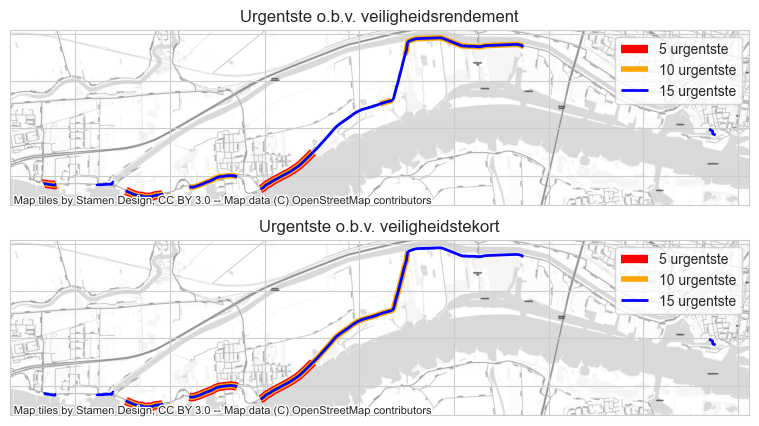

In [32]:
#urgentste N vakken:
fig,ax = plt.subplots(figsize=(12,5),nrows=2)
colors = ['red', 'orange', 'blue']
linewidths = [6, 4, 2]

for count, key in enumerate(scopes.keys()):
    if count > len(colors)-1:
        continue
    subset_greedy.loc[subset_greedy[key]].plot(ax=ax[0],categorical=True,legend=True,color=colors[count],linewidth=linewidths[count],label='{} urgentste'.format(scopes[key].shape[0]))

ctx.add_basemap(ax[0],source=ctx.providers.Stamen.TonerLite)
ax[0].legend()
ax[0].set_title('Urgentste o.b.v. veiligheidsrendement')


veiligheidstekort.loc[0:4].plot(ax=ax[1],categorical=True,legend=True,color='red',linewidth=6,label='5 urgentste')
veiligheidstekort.loc[0:9].plot(ax=ax[1],categorical=True,legend=True,color='orange',linewidth=4,label='10 urgentste')
veiligheidstekort.loc[0:14].plot(ax=ax[1],categorical=True,legend=True,color='blue',linewidth=2,label='15 urgentste')
ctx.add_basemap(ax[1],source=ctx.providers.Stamen.TonerLite)

ax[1].legend()
ax[1].set_title('Urgentste o.b.v. veiligheidstekort')

for axes in ax:
    axes.set_xticklabels('')
    axes.set_yticklabels('')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','urgentste_vakken.png'),dpi=300,bbox_inches='tight')



In [34]:
subset_greedy

,OBJECTID,NUMMER,geometry,VAKLENGTE,scope 5 vakken,scope 10 vakken,scope 15 vakken,scope 5 km,scope 7 km,scope 10 km
0,9,09,"LINESTRING (553707.136 6768828.380, 553706.151...",147.000000,False,False,False,False,False,False
1,10,10,"LINESTRING (553528.337 6768861.127, 553514.452...",129.000000,False,False,True,False,True,True
2,11,11,"LINESTRING (553388.755 6768984.079, 553388.454...",640.000000,False,False,False,False,False,True
3,13,13A,"LINESTRING (552854.355 6769457.584, 552846.089...",340.000000,False,False,False,False,False,True
4,14,13B,"LINESTRING (552362.306 6769318.015, 552362.264...",842.000000,False,False,False,False,False,True
5,15,14,"LINESTRING (551122.670 6769844.035, 551098.299...",271.000000,False,False,False,False,False,True
6,16,15,"LINESTRING (550751.434 6770074.629, 550742.733...",428.000000,False,False,False,False,False,False
7,17,16,"LINESTRING (550342.005 6769631.786, 550330.547...",578.000000,False,False,False,False,True,True
8,18,17,"LINESTRING (550155.338 6770483.780, 550153.431...",458.000000,False,False,False,False,True,True
9,19,18,"LINESTRING (549469.119 6770733.482, 549459.143...",744.000000,False,True,True,True,True,True


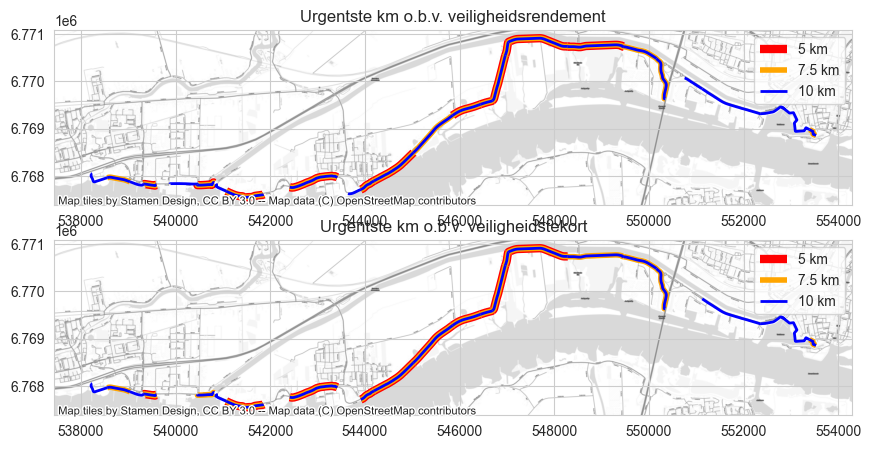

In [41]:
#scope 5, 10, 15 km:
fig,ax = plt.subplots(figsize=(12,5),nrows=2)
subset_greedy.loc[subset_greedy['scope 5 km']].plot(ax=ax[0],categorical=True,legend=True,color='red',linewidth=6,label='5 km')
subset_greedy.loc[subset_greedy['scope 7 km']].plot(ax=ax[0],categorical=True,legend=True,color='orange',linewidth=4,label='7.5 km')
subset_greedy.loc[subset_greedy['scope 10 km']].plot(ax=ax[0],categorical=True,legend=True,color='blue',linewidth=2,label='10 km')
# subset_greedy.loc[subset_greedy['scope 20 km']].plot(ax=ax[0],categorical=True,legend=True,color='cyan',linewidth=1,label='20 km')

ctx.add_basemap(ax[0],source=ctx.providers.Stamen.TonerLite)
ax[0].legend()
ax[0].set_title('Urgentste km o.b.v. veiligheidsrendement')


veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>5000].index[0]].plot(ax=ax[1],categorical=True,legend=True,color='red',linewidth=6,label='5 km')
veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>7500].index[0]].plot(ax=ax[1],categorical=True,legend=True,color='orange',linewidth=4,label='7.5 km')
veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>10000].index[0]].plot(ax=ax[1],categorical=True,legend=True,color='blue',linewidth=2,label='10 km')
ctx.add_basemap(ax[1],source=ctx.providers.Stamen.TonerLite)

ax[1].legend()
ax[1].set_title('Urgentste km o.b.v. veiligheidstekort')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','urgentste_vakken_kms.png'),dpi=300,bbox_inches='tight')



In [ ]:
#maatregelen op kaart

#kruinverhoging:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,5))
for crestheight in np.unique(GreedyResult.dcrest):
    if (crestheight >0) and (crestheight != np.max(np.unique(GreedyResult.dcrest))):
        
        GreedyResult.loc[GreedyResult.dcrest==crestheight].plot(ax=ax,color='green',linewidth=crestheight*4)
    elif crestheight >0:
        
        GreedyResult.loc[GreedyResult.dcrest==crestheight].plot(ax=ax,color='green',linewidth=crestheight*4,label='Kruinverhoging')
                           
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('Kruinverhoging')
# GreedyResult.loc[GreedyResult.VZG==1].plot(column='VZG',ax=ax,color='r',linestyle='-',linewidth=1,label='VZG')
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
ax.legend()
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kruinverhoging.png'),dpi=300,bbox_inches='tight')

In [ ]:
#maatregelen op kaart

#kruinverhoging:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,5))
GreedyResult.loc[GreedyResult.dcrest>0.].plot(ax=ax,column='dcrest',linewidth=4,categorical=True,cmap='RdYlGn_r', legend=True, legend_kwds={'bbox_to_anchor':(1.2, .8),'fontsize':16,'frameon':True})

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Kruinverhoging')
# GreedyResult.loc[GreedyResult.VZG==1].plot(column='VZG',ax=ax,color='r',linestyle='-',linewidth=1,label='VZG')
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kruinverhoging2.png'),dpi=300,bbox_inches='tight')